In [2]:
!(cd pyflow; CXXFLAGS+=-stdlib=libc++ maturin develop --release)

🔗 Found pyo3 bindings
🐍 Found CPython 3.11 at /Users/josh/josh/projects/tech/flow/.venv/bin/python
💻 Using `MACOSX_DEPLOYMENT_TARGET=10.12` for x86_64-apple-darwin by default
   Compiling flow v0.1.0 (/Users/josh/josh/projects/tech/flow/flow)
   Compiling pyflow v0.1.0 (/Users/josh/josh/projects/tech/flow/pyflow)       
    Finished `release` profile [optimized + debuginfo] target(s) in 18.96s    
📦 Built wheel for CPython 3.11 to /var/folders/w9/c8qym84j2pg4fjvx_bzr84bc0000gn/T/.tmpw77yf3/pyflow-0.1.0-cp311-cp311-macosx_10_12_x86_64.whl
🛠 Installed pyflow-0.1.0


In [25]:
import traceback

import contextplot
import numpy as np
import tqdm

import pyflow

contextplot.set_defaults()

NS_PER_S = 1e9

num_cells = 50
kinematic_viscosity = 0.

# example = 'bump_1d'
# amplitude = 0.2
# width = 0.2
# t_max = 5
# solver = getattr(pyflow, example)(num_cells, num_z_cells, kinematic_viscosity, amplitude, width)

example = "bump_2d_spectral"
base_height = 3
amplitude = 0.01
solver = getattr(pyflow, example)(
    num_cells, kinematic_viscosity, base_height, amplitude
)

t_max = 2
speedup_factor = 0.4
frame_rate_hz = 30

t_max_ns = int(t_max * NS_PER_S)
dt_plot_ns = int(1 / frame_rate_hz * speedup_factor * NS_PER_S)


def frame_index(t_ns: int):
    return t_ns // dt_plot_ns


with contextplot.context_video(
    f"videos/{example}_sphere_quiver_debug.mp4",
    1,
    size_inches=(4, 2.5),
    dpi=300,
    frame_rate_hz=frame_rate_hz,
) as cv:
    x_axis = solver.x_axis
    y_axis = solver.y_axis

    x_grid, y_grid = np.meshgrid(x_axis, y_axis, indexing='ij')

    try:
        t_ns = 0
        bar = tqdm.tqdm(total=t_max_ns)
        while t_ns < t_max_ns:
            with cv.next_frame() as cp:
                fields = solver.fields
                height = fields.height
                velocity = fields.velocity

                _ = cp.figure.colorbar(cp.ax.imshow(height))
                output = cp.ax.quiver(
                    # x_grid,
                    # y_grid,
                    velocity[1],
                    velocity[0],
                    scale=0.5,
                )
                # cp.ax.set(
                #     xlim=[-(R + 0.1 * r), (R + 0.1 * r)],
                #     ylim=[-(R + 0.1 * r), (R + 0.1 * r)],
                #     zlim=[-r * 1.1, r * 1.1],
                #     aspect="equal",
                # )
                # cp.ax.set_axis_off()

            solver.integrate(dt_plot_ns / NS_PER_S)
            t_ns += dt_plot_ns
            if t_ns > t_max_ns:
                break
            _ = bar.update(dt_plot_ns)

    except KeyboardInterrupt:
        pass
    except BaseException:
        traceback.print_exc()
    finally:
        bar.close()

  0%|          | 0/2000000000 [00:00<?, ?it/s]/var/folders/w9/c8qym84j2pg4fjvx_bzr84bc0000gn/T/ipykernel_31302/3762864637.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  _ = cp.figure.colorbar(cp.ax.imshow(height))
100%|█████████▉| 1999999950/2000000000 [01:04<00:00, 30868679.36it/s]


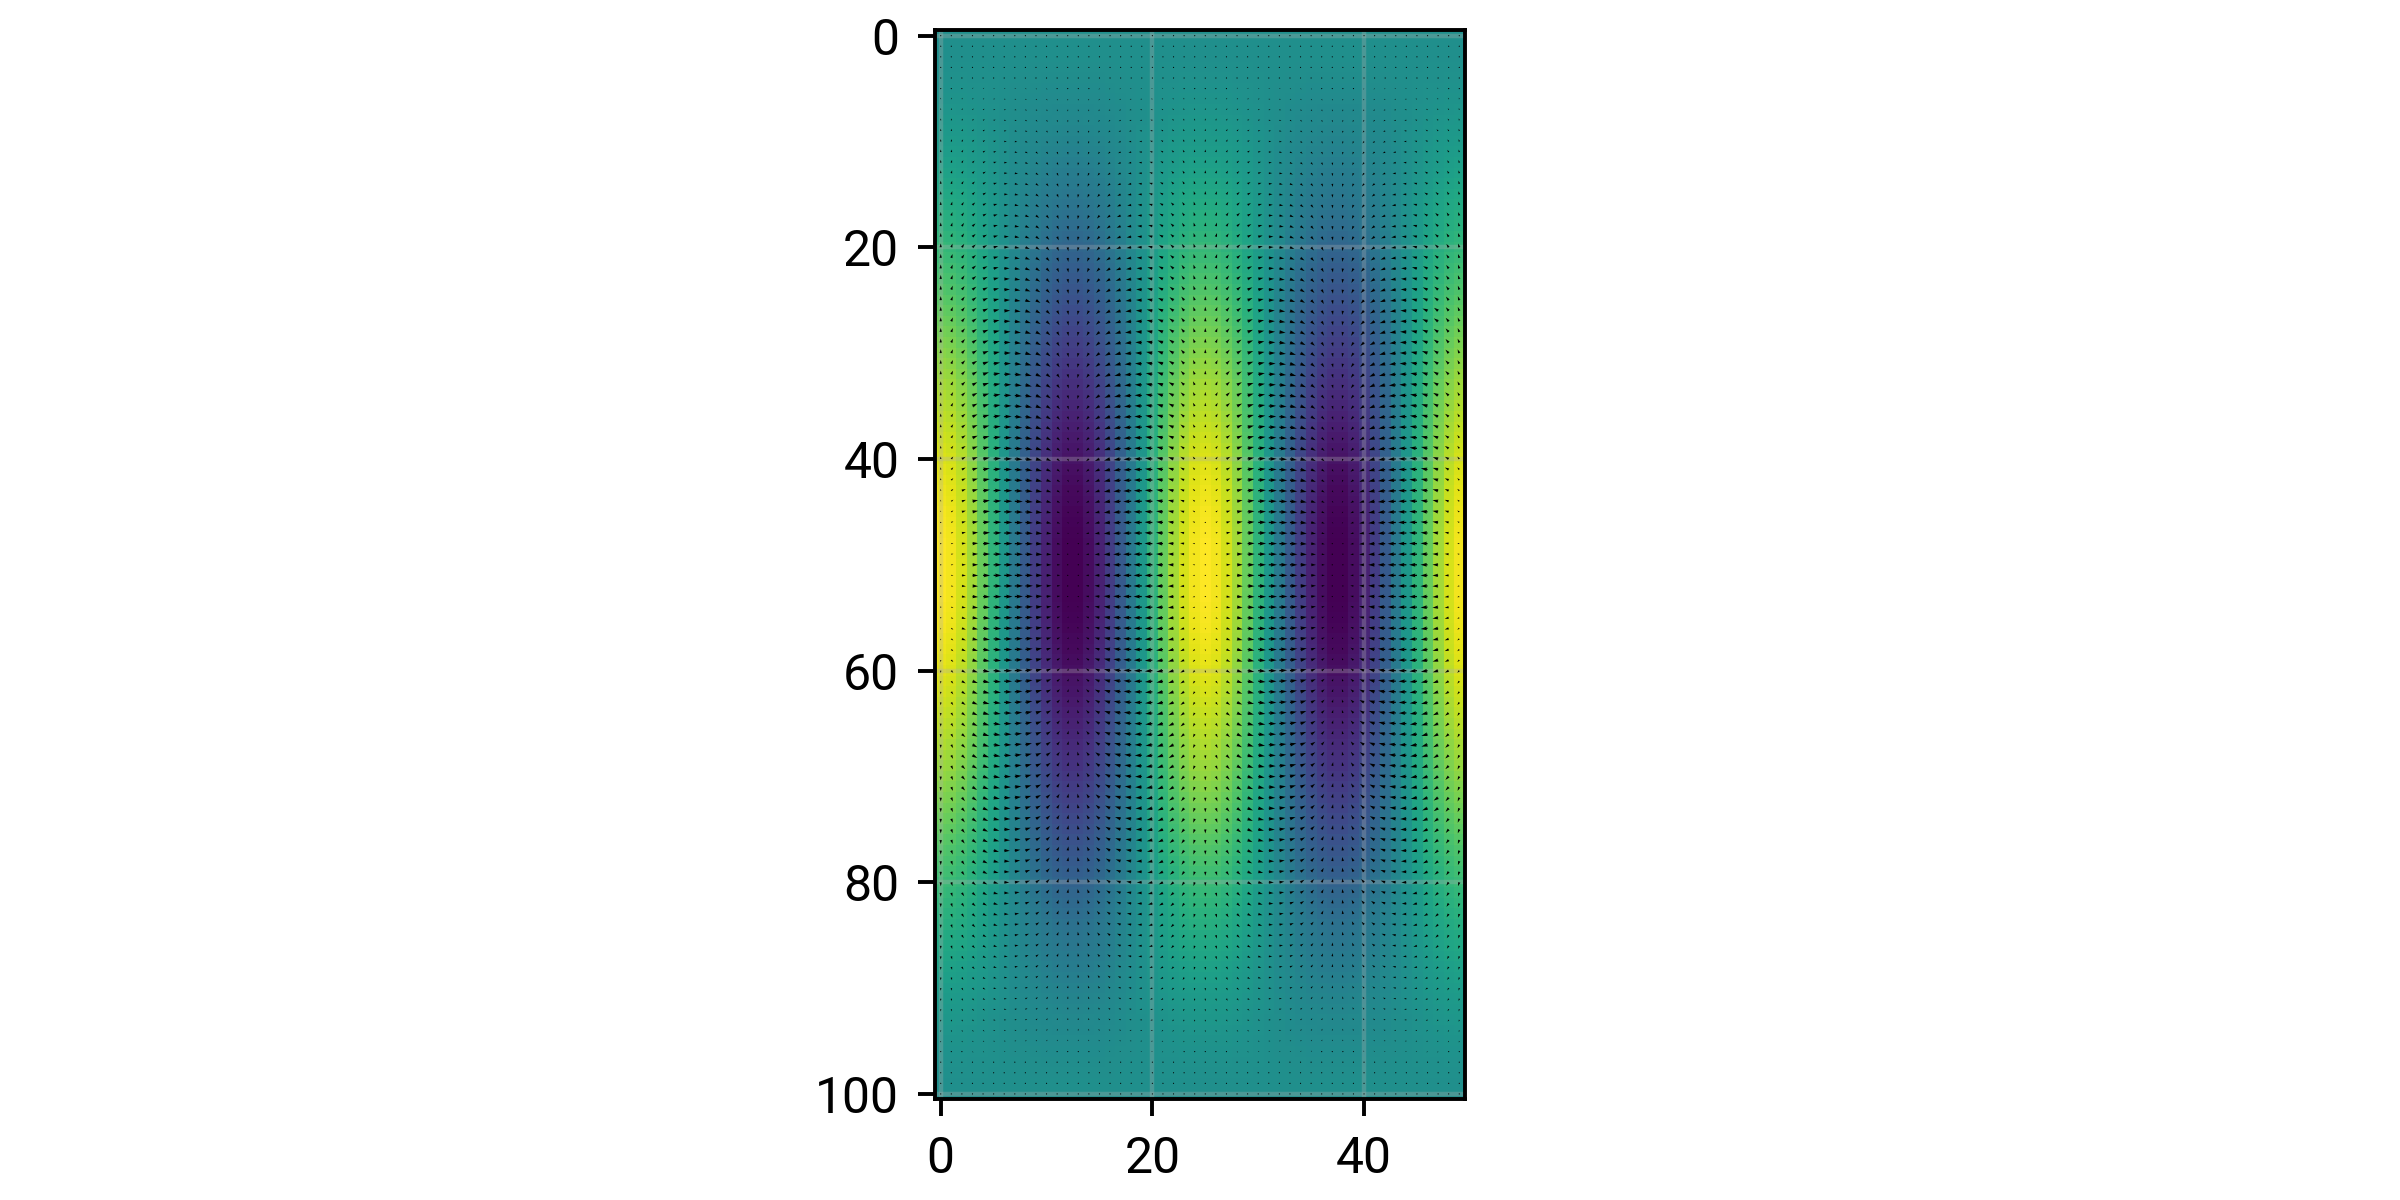

In [16]:
phi = np.linspace(0, 2*np.pi, 50, endpoint=False)[np.newaxis, :]
theta = np.linspace(0, np.pi, 101, endpoint=False)[:, np.newaxis]

Y22_p_Y2m2 = 1/4 * np.sqrt(15 / 2/np.pi) * np.sin(theta)**2 * 2 * np.cos(2 * phi)
Psi22_p_Psi2m2_th = np.sin(theta) * (2 * np.cos(theta) * np.cos(2 * phi))
Psi22_p_Psi2m2_ph = np.sin(theta) * (2 * np.sin(2 * phi))

with contextplot.context_plot() as cp:
    cp.ax.imshow(Y22_p_Y2m2)
    cp.ax.quiver(Psi22_p_Psi2m2_ph, Psi22_p_Psi2m2_th)